# Multivariate Generalized Gaussian Spatial Model

## Stochastic representation: $\mathbf{x} = \tau \Sigma^{1/2} \mathbf{u}$
1. $\mathbf{u} \in \mathbb{R}^2$ is a random vector sampled from a unit circle
2. Scatter matrix $\Sigma = m \mathbf{M}$
3. Shape parameter $\beta$
4. $\tau^{2 \beta} \sim \Gamma(\frac{p}{2 \beta}, 2)$

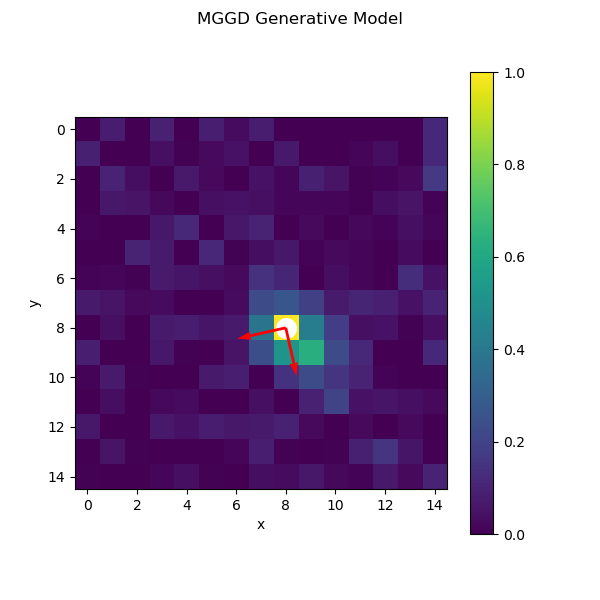

In [1]:
%matplotlib widget
from random import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from numpy import linalg as LA
from scipy.optimize import minimize


def genScatter(alpha=None, p=2):
    if alpha is None:
        alpha = random() * 2 * np.pi
    beta = alpha + np.pi / 2.0

    Q = np.array([[np.cos(alpha), np.cos(beta)], [np.sin(alpha), np.sin(beta)]])
    P = np.diag(np.random.rand(2))
    M = np.matmul(np.matmul(Q, P), LA.inv(Q))

    return M * p / M.trace()


def normalize2(xs, scope, dtype=int):
    xs = (xs - xs.min()) / (xs.max() - xs.min()) * (scope - 1)
    return np.clip(np.round(xs), 0, scope - 1).astype(dtype)


def generate_image(beta, m, M, p=2):
    nsamples = 1000
    # Stochastic process
    Sigma = np.sqrt(np.abs(m * M))
    phi = 2 * np.pi * np.random.random(nsamples) - np.pi
    u = np.array([np.cos(phi), np.sin(phi)])
    tau = np.power(np.random.gamma(0.5 * p / beta, 2, nsamples), 0.5 / beta)
    x = tau * np.matmul(Sigma, u)

    x = normalize2(x, 15)

    im = np.zeros((15, 15), dtype=int)
    for ns in np.arange(nsamples):
        im[x[0, ns], x[1, ns]] += 1
    noise = np.random.normal(np.mean(im), 0.5 * np.sqrt(np.var(im)), im.shape)
    im += np.round(noise).astype(int)
    im[im < 0] = 0
    im = (im - im.min()) / (im.max() - im.min())

    X, Y = np.meshgrid(np.linspace(1, 16, 15), np.linspace(1, 16, 15))
    center = (
        np.round(np.sum(X * im / np.sum(im))) - 1,
        np.round(np.sum(Y * im / np.sum(im))) - 1,
    )
    w, v = LA.eig(M)
    X = [center[1], center[1]]
    Y = [center[0], center[0]]
    U = v[0, :]
    V = v[1, :]

    return im, center, v


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
im, center, v = generate_image(0.5, 10, genScatter())
image = ax.imshow(im)
scatter = ax.scatter(center[1], center[0], s=200, c="w")
quiver = ax.quiver(
    [center[1], center[1]],
    [center[0], center[0]],
    v[0, :],
    v[1, :],
    color="r",
    scale_units="xy",
    scale=0.5,
)
fig.colorbar(image, ax=ax)


def init():
    im, center, v = generate_image(
        np.random.rand(1) * 6, np.random.rand(1) * 15, genScatter()
    )
    image.set_data(im)
    scatter.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])

    return image, dot, quiver


def update(frame):
    beta = np.random.rand(1) * 6
    im, center, v = generate_image(beta, np.random.rand(1) * 15, genScatter())
    image.set_data(im)
    scatter.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])
    ax.set_title(r"$\beta = $ %.1f" % beta[0])

    return image, dot, quiver


ani = FuncAnimation(fig, update, frames=100, interval=400, init_func=init, blit=True)

plt.suptitle("MGGD Generative Model")
plt.show()

## Parameter estimation with max log-likelihood

In [15]:
import nengo
import numpy as np
import tensorflow as tf
from scipy.optimize import minimize

d = 2

class MultiVarGenGaussian:
    def __init__(self, mu, Sigma, beta):
        self.mu = mu
        self.Sigma = Sigma
        self.beta = beta

    def pdf(self, X):
        d = X.shape[1]
        diff = X - self.mu
        exponent = -0.5 * np.sum(
            np.power(np.dot(diff, np.linalg.inv(self.Sigma)), 2), axis=1
        )
        exponent = np.power(1 + exponent / self.beta, -(self.beta + d) / 2)
        return np.prod(exponent)

    def log_likelihood(self, X):
        return np.sum(np.log(self.pdf(X)))

def estimate_params(X):
    n, d = X.shape
    mu0 = np.mean(X, axis=0)
    Sigma0 = np.cov(X.T)
    beta0 = 1.0
    model = MultiVarGenGaussian(mu0, Sigma0, beta0)
    res = minimize(lambda beta: -model.log_likelihood(X), beta0, method="BFGS")
    beta_hat = res.x[0]
    model.beta = beta_hat
    return model

X = (np.random.randn(100, 2) + 1)  # generate 100 samples from a 2-dimensional normal distribution
model = estimate_params(X)

/tmp/ipykernel_9862/1294138806.py:21: RuntimeWarning: invalid value encountered in power
  exponent = np.power(1 + exponent / self.beta, -(self.beta + d) / 2)


## Parameter Estimation with Neural Sampling
* Nengo

In [ ]:
import nengo
import numpy as np

# Define the number of dimensions for the ensemble
n_dims = 3

# Create the Nengo model
model = nengo.Network(label="Multivariate Generalized Gaussian Parameter Estimation")
with model:
    # Create the input ensemble that represents the data
    data = nengo.Ensemble(n_neurons=100, dimensions=n_dims)
    
    # Create the output ensemble that represents the parameters
    params = nengo.Ensemble(n_neurons=100, dimensions=n_dims + 1)
    
    # Connect the input ensemble to the output ensemble
    nengo.Connection(data, params, function=lambda x: np.concatenate([x, [1]]))
    
    # Define the function that implements the parameter estimation
    def estimate(t, x):
        mu = np.mean(x[:n_dims], axis=0)
        sigma = np.cov(x[:n_dims], rowvar=False)
        alpha = np.power(np.linalg.det(sigma), -0.5)
        return np.concatenate([mu, [alpha]])
    
    # Connect the output ensemble to a node that implements the parameter estimation
    node = nengo.Node(estimate, size_in=n_dims + 1)
    nengo.Connection(params, node, synapse=None)
    
    # Define the function that implements the sampling
    def sample(t, x):
        index = np.argmax(x)
        return [1 if i == index else 0 for i in range(n_dims + 1)]
    
    # Connect the output ensemble to a node that implements the sampling
    node = nengo.Node(sample, size_in=n_dims + 1)
    nengo.Connection(params, node, synapse=None)

# Simulate the model
with nengo.Simulator(model) as sim:
    # Provide input to the model
    input = np.random.rand(n_dims)
    sim.data[data].feed = input
    
    sim.run(10)